In [2]:
import numpy as np
import matplotlib.pyplot as plt
try:
    from sklearn.datasets.samples_generator import make_blobs
except:
    from sklearn.datasets import make_blobs

%matplotlib inline

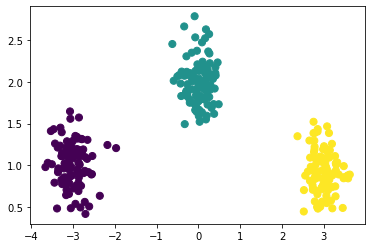

In [3]:
# Create the  training data
np.random.seed(2)
X, y = make_blobs(n_samples=300,cluster_std=.25, centers=np.array([(-3,1),(0,2),(3,1)]))
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

# One VS All

In [36]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone
from sklearn.utils.multiclass import unique_labels

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """
    One-vs-all classifier
    We assume that the classes will be the integers 0,..,(n_classes-1).
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class.
    """
    def __init__(self, estimator, n_classes):      
        """
        Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)
        @param estimator : binary base classifier used
        @param n_classes : number of classes
        """
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        """
        This should fit one classifier for each class.
        self.estimators[i] should be fit on class i vs rest
        @param X: array-like, shape = [n_samples,n_features], input data
        @param y: array-like, shape = [n_samples,] class labels
        @return returns self
        """
        #Your code goes here
        #First classifier classifying samples with label_0 from samples with other labels
        y_0 = y.copy()
        for i in range(X.shape[0]):
            if y_0[i] != 0:
                 y_0[i] = -1 
        self.estimators[0].fit(X, y_0)#fit on class 0 vs. rest
        
        #Second classifier classifying samples with label_1 from samples with other labels
        y_1 = y.copy()
        for i in range(X.shape[0]):
            if y_1[i] != 1:
                 y_1[i] = 0
        self.estimators[1].fit(X, y_1)#fit on class 1 vs. rest
        
        #Third classifier classifying samples with label_2 from samples with other labels
        y_2 = y.copy()
        for i in range(X.shape[0]):
            if y_2[i] != 2:
                 y_2[i] = 1  
        self.estimators[2].fit(X, y_2)#fit on class 2 vs. rest        
        
        self.fitted = True
        
        return self   

    def decision_function(self, X):
        """
        Returns the score of each input for each class. Assumes
        that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        @param X : array-like, shape = [n_samples, n_features] input data
        @return array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")
        
        des_0 = self.estimators[0].decision_function(X)#the score of class 0 vs. other classes
        des_1 = self.estimators[1].decision_function(X)#the score of class 1 vs. other classes
        des_2 = self.estimators[2].decision_function(X)#the score of class 2 vs. other classes
        
        des_0 = np.expand_dims(des_0, axis=1)
        des_1 = np.expand_dims(des_1, axis=1)
        des_2 = np.expand_dims(des_2, axis=1)
        
        conf_score = np.hstack((des_0,des_1,des_2))
        
        return conf_score
    
    def predict(self, X):
        """
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples,n_features] input data
        @returns array-like, shape = [n_samples,] the predicted classes for each input
        """
        prediction = np.argmax(self.decision_function(X), axis=1)
        
        return prediction

Coeffs 0
[[-1.05853712 -0.90295222]]
Coeffs 1
[[-0.2838078  0.3489447]]
Coeffs 2
[[ 0.89164451 -0.82601203]]


/Users/opal/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


array([[100,   0,   0],
       [  0, 100,   0],
       [  0,   0, 100]])

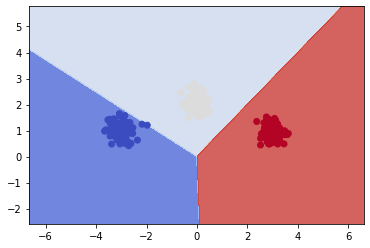

In [30]:
#Here we test the OneVsAllClassifier
from sklearn import svm
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=200)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X,y)

for i in range(3) :
    print("Coeffs %d"%i)
    print(clf_onevsall.estimators[i].coef_) #Will fail if you haven't implemented fit yet

# create a mesh to plot in
h = .02  # step size in the mesh
x_min, x_max = min(X[:,0])-3,max(X[:,0])+3
y_min, y_max = min(X[:,1])-3,max(X[:,1])+3
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
mesh_input = np.c_[xx.ravel(), yy.ravel()]

Z = clf_onevsall.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)

from sklearn import metrics
metrics.confusion_matrix(y, clf_onevsall.predict(X))

## Multiclass SVM

In [70]:
def zeroOne(y,a) :
    '''
    Computes the zero-one loss.
    @param y: output class
    @param a: predicted class
    @return 1 if different, 0 if same
    '''
    return int(y != a)

def featureMap(X,y,num_classes) :
    '''
    Computes the class-sensitive features.
    @param X: array-like, shape = [n_samples,n_inFeatures] or [n_inFeatures,], input features for input data
    @param y: a target class (in range 0,..,num_classes-1)
    @return array-like, shape = [n_samples,n_outFeatures], the class sensitive features for class y
    '''
    #The following line handles X being a 1d-array or a 2d-array
    num_samples, num_inFeatures = (1,X.shape[0]) if len(X.shape) == 1 else (X.shape[0],X.shape[1])
    
    phi_x_y = np.zeros((num_samples,num_inFeatures*num_classes))#initialize feature map
    for i in range(num_samples):
        for j in range(num_classes):
            if y == j:
                phi_x_y[i:i+1,j*num_inFeatures:j*num_inFeatures+num_inFeatures] = X[i:i+1,:]
            else:
                pass
    return phi_x_y

def sgd(X, y, num_outFeatures, subgd, eta = 0.1, T = 10000):
    '''
    Runs subgradient descent, and outputs resulting parameter vector.
    @param X: array-like, shape = [n_samples,n_features], input training data 
    @param y: array-like, shape = [n_samples,], class labels
    @param num_outFeatures: number of class-sensitive features
    @param subgd: function taking x,y,w and giving subgradient of objective
    @param eta: learning rate for SGD
    @param T: maximum number of iterations
    @return: vector of weights
    '''
    num_samples = X.shape[0]
    w = np.zeros((1,num_outFeatures))#initialize weights vector
    
    for t in range(T):
        i = np.random.choice(num_samples)
        w = w - eta*subgd(X[i:i+1,:], y[i], w)
        
    return w                                  

class MulticlassSVM(BaseEstimator, ClassifierMixin):
    '''
    Implements a Multiclass SVM estimator.
    '''
    def __init__(self, num_outFeatures, lam=1.0, num_classes=3, Delta=zeroOne, Psi=featureMap):       
        '''
        Creates a MulticlassSVM estimator.
        @param num_outFeatures: number of class-sensitive features produced by Psi
        @param lam: l2 regularization parameter
        @param num_classes: number of classes (assumed numbered 0,..,num_classes-1)
        @param Delta: class-sensitive loss function taking two arguments (i.e., target margin)
        @param Psi: class-sensitive feature map taking two arguments
        '''
        self.num_outFeatures = num_outFeatures
        self.lam = lam
        self.num_classes = num_classes
        self.Delta = Delta
        self.Psi = lambda X,y : Psi(X,y,num_classes)
        self.fitted = False
    
    def subgradient(self,x,y,w):
        '''
        Computes the subgradient at a given data point x,y
        @param x: sample input
        @param y: sample class
        @param w: parameter vector
        @return returns subgradient vector at given x,y,w
        '''      
        max_ = 0
        for cls in range(self.num_classes-1):
            temp = self.Delta(y, cls+1) + np.dot(w, (self.Psi(x,cls+1)-self.Psi(x,y)).T)
            if temp > self.Delta(y, max_) + np.dot(w, (self.Psi(x,max_)-self.Psi(x,y)).T):
                max_ = cls + 1
                
        return 2*self.lam*w + self.Psi(x,max_)-self.Psi(x,y)
        
    def fit(self,X,y,eta=0.1,T=10000):
        '''
        Fits multiclass SVM
        @param X: array-like, shape = [num_samples,num_inFeatures], input data
        @param y: array-like, shape = [num_samples,], input classes
        @param eta: learning rate for SGD
        @param T: maximum number of iterations
        @return returns self
        '''
        self.coef_ = sgd(X,y,self.num_outFeatures,self.subgradient,eta,T)
        self.fitted = True
        return self
    
    def decision_function(self, X):
        '''
        Returns the score on each input for each class. Assumes
        that fit has been called.
        @param X : array-like, shape = [n_samples, n_inFeatures]
        @return array-like, shape = [n_samples, n_classes] giving scores for each sample,class pairing
        '''
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")
            
        n_samples = X.shape[0]
        conf_score = np.zeros((n_samples, self.num_classes))
        for i in range(n_samples):
            for j in range(self.num_classes):
                conf_score[i][j] = np.dot(self.coef_, self.Psi(X[i:i+1,:],j).T)
        
        return conf_score 
                
    def predict(self, X):
        '''
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples, n_inFeatures], input data to predict
        @return array-like, shape = [n_samples,], class labels predicted for each data point
        '''
        prediction = np.argmax(self.decision_function(X), axis=1)
        
        return prediction

w:
[[-0.22584545 -0.12082331 -0.00898836  0.31673086  0.23483381 -0.19590755]]


array([[ 95,   5,   0],
       [  0, 100,   0],
       [  0,   8,  92]])

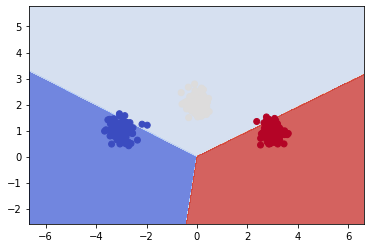

In [71]:
#the following code tests the MulticlassSVM and sgd
#will fail if MulticlassSVM is not implemented yet
est = MulticlassSVM(6,lam=1)
est.fit(X,y,eta=0.1)
print("w:")
print(est.coef_)
Z = est.predict(mesh_input)
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
# Plot also the training points
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)


from sklearn import metrics
metrics.confusion_matrix(y, est.predict(X))